<a href="https://colab.research.google.com/github/FrankAyalaC/sensitivity_analysis_WW3/blob/main/Plotting_error_maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import datetime as dt
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.dates as mdates
import matplotlib as mpl
import pandas as pd
import os
from datetime import datetime,timedelta
import glob as glob
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.dates import DateFormatter
import matplotlib.gridspec as gridspec
from matplotlib.colors import DivergingNorm

newparams = { 'axes.grid': False,
             'lines.linewidth': 1.5, 'lines.linewidth': 2,
             'ytick.labelsize':15,
             'xtick.labelsize':15,
             'axes.labelsize':16,
             'axes.titlesize':18,
            'legend.fontsize':14,
             'figure.titlesize':16,
             'font.family':'Helvetica Light'}
plt.rcParams.update(newparams)

from datetime import datetime,timedelta

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_track=pd.read_csv('/content/drive/Othercomputers/Mi PC/Tesis Maestria FranklinAyala/Scripts/Sensitivity analysis/df_track.csv',
                     sep=' ',names=['date','lat','lon','wind','id','color','cat'])

In [ ]:
df_track=df_track.set_index('date')

In [ ]:
df_interest=df_track.iloc[:17]

In [ ]:
data_array=df_interest.index
cat_array=df_interest.cat.values
dates_org=pd.to_datetime(data_array)
data_str=dates_org.strftime('%m/%d/%H')

In [ ]:
def get_index_positions(list_of_elems, element):
  ''' Returns the indexes of all occurrences of give element in
  the list- listOfElements '''
  index_pos_list = []
  index_pos = 0
  while True:
      try:
          # Search for item in list from indexPos to the end of list
          index_pos = list_of_elems.index(element, index_pos)
          # Add the index position in list
          index_pos_list.append(index_pos)
          index_pos += 1
      except ValueError as e:
          break
  return index_pos_list

In [ ]:
dic_cats={}

In [ ]:
dic_cats['H1']=get_index_positions(cat_array.tolist(),'H1')
dic_cats['H2']=get_index_positions(cat_array.tolist(),'H2')
dic_cats['H3']=get_index_positions(cat_array.tolist(),'H3')
dic_cats['H4']=get_index_positions(cat_array.tolist(),'H4')
dic_cats['H5']=get_index_positions(cat_array.tolist(),'H5')

In [ ]:
cat_array

array(['H1', 'H1', 'H2', 'H3', 'H3', 'H4', 'H4', 'H2', 'H3', 'H4', 'H4',
       'H4', 'H5', 'H4', 'H4', 'H4', 'H4'], dtype=object)

In [ ]:
ds_specs=np.load('/content/drive/Othercomputers/Mi PC/Tesis Maestria FranklinAyala/Scripts/Sensitivity analysis/efth_spec.npz',
                 allow_pickle=True)

In [ ]:
specs_sw3=ds_specs['sw3'].flatten()[0]

In [ ]:
specs_sw3.keys()

dict_keys(['ALPHA0/-10', 'ALPHA0/-30', 'ALPHA0/-50', 'ALPHA0/0', 'ALPHA0/10', 'ALPHA0/30', 'ALPHA0/50', 'BETAMAX/-10', 'BETAMAX/-30', 'BETAMAX/-50', 'BETAMAX/0', 'BETAMAX/10', 'BETAMAX/30', 'BETAMAX/50', 'SINTHP/-10', 'SINTHP/-30', 'SINTHP/-50', 'SINTHP/0', 'SINTHP/10', 'SINTHP/30', 'SINTHP/50', 'SWELLF/-10', 'SWELLF/-30', 'SWELLF/-50', 'SWELLF/0', 'SWELLF/10', 'SWELLF/30', 'SWELLF/50', 'Z0MAX/-10', 'Z0MAX/-30', 'Z0MAX/-50', 'Z0MAX/0', 'Z0MAX/10', 'Z0MAX/30', 'Z0MAX/50', 'ZALP/-10', 'ZALP/-30', 'ZALP/-50', 'ZALP/0', 'ZALP/10', 'ZALP/30', 'ZALP/50', 'ZWND/-10', 'ZWND/-30', 'ZWND/-50', 'ZWND/0', 'ZWND/10', 'ZWND/30', 'ZWND/50'])

In [ ]:
freqs=[0.042, 0.0462, 0.05082001, 0.05590201, 0.06149221, 0.06764144,
    0.07440558, 0.08184613, 0.09003075, 0.09903383, 0.1089372, 0.1198309,
    0.131814, 0.1449955, 0.159495, 0.1754445, 0.192989, 0.2122879, 0.2335167,
    0.2568683, 0.2825552, 0.3108107, 0.3418918, 0.376081, 0.4136891,
    0.455058, 0.5005639, 0.5506203, 0.6056823, 0.6662505]

In [ ]:
def arranging_axes(ax,xlabel):
  ax.set_xticks(np.linspace(0,36,5))
  ax.set_xticklabels(list(map(str,np.linspace(0,360,5,dtype=int))))
  ax.set_yticks(np.arange(0,31,10))
  ax.set_yticklabels(np.round([freqs[0],freqs[9],freqs[19],freqs[29]],2))
  if xlabel==1:
    ax.set_xlabel('Direction [°]') 

In [ ]:
def computing_example(data_spec,param_name):
  list_result=[]
  min_values=[]
  max_values=[]
  objs=[]
  for param in data_spec.keys():
    def_name=param_name+'/0'
    if param !=def_name and param[:6] ==param_name:
      default=np.reshape(specs_sw3[def_name][:85,:,:],(17,5,30,36)) 
      obj=np.reshape(specs_sw3[param][:85,:,:],(17,5,30,36))
      default=default[1,1,:,:]
      obj=obj[1,1,:,:]
      #result=(np.abs((obj-default)/(np.nanmax(default))))*100
      result=obj-default
      list_result.append(result)
      objs.append(obj)
      a=min([np.nanmin(obj),np.nanmin(default)])
      b=max([np.nanmax(obj),np.nanmax(default)])
      min_values.append(a)
      max_values.append(b)
  return default,objs,list_result,min_values,max_values

In [ ]:
default,objs,list_result,min_values,max_values=computing_example(specs_sw3,'SINTHP')

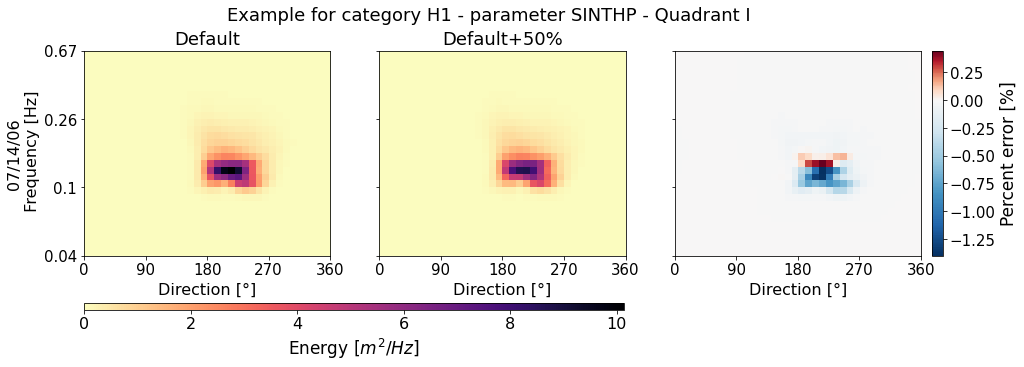

In [ ]:
import matplotlib.colors as colors

fig,[ax1,ax2,ax3]=plt.subplots(1,3,figsize=(15,5),sharex=True,sharey=True)

cf=ax1.imshow(default,vmin=min_values[-1],vmax=max_values[-1],extent=[0,36,0,30],origin='lower',cmap='magma_r')
ax1.set_ylabel(data_str[1]+'\n Frequency [Hz]', multialignment='center')
ax1.set_title('Default')

ax2.imshow(objs[-1],vmin=min_values[-1],vmax=max_values[-1],extent=[0,36,0,30],origin='lower',cmap='magma_r')
ax2.set_title('Default+50%')

norm = colors.TwoSlopeNorm(vmin=list_result[-1].min(), vcenter=0, vmax=list_result[-1].max())
cf2=ax3.imshow(list_result[-1],extent=[0,36,0,30],origin='lower',norm=norm,cmap='RdBu_r')

cax1= fig.add_axes([ax1.get_position().x0,ax1.get_position().y0-0.15,0.5,0.02])
cbar=plt.colorbar(cf,cax=cax1,orientation="horizontal",pad=0.12)
cbar.set_label(r'Energy [$m^{2}/Hz$]',fontsize=17)
cbar.ax.tick_params(labelsize=16)

cax2= fig.add_axes([ax3.get_position().x1+0.01,ax3.get_position().y0,0.01,ax3.get_position().height])
cbar2=plt.colorbar(cf2,cax=cax2,orientation="vertical",pad=0.12)
cbar2.set_label(r'Percent error [%]',fontsize=17)

arranging_axes(ax1,1)
arranging_axes(ax2,1)
arranging_axes(ax3,1)

plt.suptitle('Example for category H1 - parameter SINTHP - Quadrant I',fontsize=18,y=0.91)
plt.savefig('/content/drive/Othercomputers/Mi PC/Tesis Maestria FranklinAyala/Scripts/Sensitivity analysis/init_basic_plot.png',
            dpi=1000,bbox_inches='tight',pad_inches=0.05)
plt.show()

In [96]:
def plotting_example(default,objs,results,min_values,max_values):
  porcentages=['-10%','-30%','-50%','+10%','+30%','+50%']
  #fig,axes=plt.subplots(6,3,figsize=(15,30),sharex=True,sharey=True)
  fig=plt.figure(figsize=(15,35))
  gs = gridspec.GridSpec(7, 3,fig,wspace=-0.4,hspace = 1.1)
  for idx in range(len(results)):
    ax1=fig.add_subplot(gs[idx,0])
    ax2=fig.add_subplot(gs[idx,1])
    ax3=fig.add_subplot(gs[idx,2])   
    plt.setp(ax2.get_yticklabels(), visible=False)                 
    plt.setp(ax3.get_yticklabels(), visible=False)                 
    cf=ax1.imshow(default,vmin=min_values[idx],vmax=max_values[idx],
                           extent=[0,36,0,30],origin='lower',cmap='magma_r')
    ax1.set_ylabel(data_str[1]+'\n Frequency [Hz]', multialignment='center')
    ax1.set_title('Default')

    ax2.imshow(objs[idx],vmin=min_values[idx],vmax=max_values[idx],
                        extent=[0,36,0,30],origin='lower',cmap='magma_r')
    ax2.set_title('Default'+porcentages[idx])

    norm = colors.TwoSlopeNorm(vmin=results[idx].min(), vcenter=0, vmax=results[idx].max())
    cf2=ax3.imshow(results[idx],extent=[0,36,0,30],origin='lower',norm=norm,cmap='RdBu_r')

    arranging_axes(ax1,1)
    arranging_axes(ax2,1)
    arranging_axes(ax3,1)

    cax1= fig.add_axes([ax1.get_position().x0,ax1.get_position().y0-0.025,0.365,0.003])
    cbar=plt.colorbar(cf,cax=cax1,orientation="horizontal",pad=0.12)
    cbar.set_label(r'Energy [$m^{2}/Hz$]',fontsize=15)
    cbar.ax.tick_params(labelsize=15)

    cax2= fig.add_axes([ax3.get_position().x1+0.01,ax3.get_position().y0,
                        0.01,ax3.get_position().height])
    cbar2=plt.colorbar(cf2,cax=cax2,orientation="vertical",pad=0.12)
    cbar2.set_label(r'Percent Error [%]',fontsize=15)
    cbar2.ax.tick_params(labelsize=15)

  zeros=np.zeros(default.shape)        
  for el in list_result:
    zeros=zeros+el
  final_value=zeros/6          
  final_value.shape          
  ax_final=fig.add_subplot(gs[6,2])
  norm_f = colors.TwoSlopeNorm(vmin=final_value.min(), vcenter=0, vmax=final_value.max())
  cf_final=ax_final.imshow(final_value,extent=[0,36,0,30],origin='lower',norm=norm_f,cmap='RdBu_r')
  ax_final.set_title('Mean error map')
  arranging_axes(ax_final,1)
  cax_final= fig.add_axes([ax_final.get_position().x1+0.01,ax_final.get_position().y0,
                        0.01,ax_final.get_position().height])
  cbar3=plt.colorbar(cf_final,cax=cax_final,orientation="vertical",pad=0.12)
  cbar3.set_label(r'Percent Error [%]',fontsize=15)
  cbar3.ax.tick_params(labelsize=15)

  plt.suptitle('Percent error maps for estimating a mean error map for quadrant I and SINTHP',fontsize=18,y=0.91)
  plt.savefig('/content/drive/Othercomputers/Mi PC/Tesis Maestria FranklinAyala/Scripts/Sensitivity analysis/adv_basic_plot2.png',
            dpi=1000,bbox_inches='tight',pad_inches=0.05)
  plt.show()


In [113]:
def plotting_example_v2(default,objs,results,min_values,max_values):
  porcentages=['-10%','-30%','-50%','+10%','+30%','+50%']
  #fig,axes=plt.subplots(6,3,figsize=(15,30),sharex=True,sharey=True)
  fig=plt.figure(figsize=(18,11))
  gs = gridspec.GridSpec(4, 6,fig,wspace=0.2,hspace = 0.5)
  for idx in range(len(results)):
    ax2=fig.add_subplot(gs[1,idx])
    ax3=fig.add_subplot(gs[2,idx])   
    plt.setp(ax2.get_yticklabels(), visible=False)                 
    plt.setp(ax3.get_yticklabels(), visible=False)                 

    ax1=fig.add_subplot(gs[0,3])
    cf=ax1.imshow(default,vmin=min_values[idx],vmax=max_values[idx],
                           extent=[0,36,0,30],origin='lower',cmap='magma_r')
    ax1.set_ylabel(data_str[1]+'\n Frequency [Hz]', multialignment='center')
    ax1.set_title('Default')

    ax2.imshow(objs[idx],vmin=min_values[idx],vmax=max_values[idx],
                        extent=[0,36,0,30],origin='lower',cmap='magma_r')
    ax2.set_title('Default'+porcentages[idx])

    norm = colors.TwoSlopeNorm(vmin=results[idx].min(), vcenter=0, vmax=results[idx].max())
    cf2=ax3.imshow(results[idx],extent=[0,36,0,30],origin='lower',norm=norm,cmap='RdBu_r')

    arranging_axes(ax1,1)
    arranging_axes(ax2,1)
    arranging_axes(ax3,1)

    #cax1= fig.add_axes([ax1.get_position().x0,ax1.get_position().y0-0.025,0.365,0.003])
    #cbar=plt.colorbar(cf,cax=cax1,orientation="horizontal",pad=0.12)
    #cbar.set_label(r'Energy [$m^{2}/Hz$]',fontsize=15)
    #cbar.ax.tick_params(labelsize=15)

    #cax2= fig.add_axes([ax3.get_position().x1+0.01,ax3.get_position().y0,
    #                    0.01,ax3.get_position().height])
    #cbar2=plt.colorbar(cf2,cax=cax2,orientation="vertical",pad=0.12)
    #cbar2.set_label(r'Percent Error [%]',fontsize=15)
    #cbar2.ax.tick_params(labelsize=15)

  zeros=np.zeros(default.shape)        
  for el in list_result:
    zeros=zeros+el
  final_value=zeros/6          
  final_value.shape          
  ax_final=fig.add_subplot(gs[3,3])
  norm_f = colors.TwoSlopeNorm(vmin=final_value.min(), vcenter=0, vmax=final_value.max())
  cf_final=ax_final.imshow(final_value,extent=[0,36,0,30],origin='lower',norm=norm_f,cmap='RdBu_r')
  #ax_final.set_title('Mean error map')
  # arranging_axes(ax_final,1)
  # cax_final= fig.add_axes([ax_final.get_position().x1+0.01,ax_final.get_position().y0,
  #                       0.01,ax_final.get_position().height])
  # cbar3=plt.colorbar(cf_final,cax=cax_final,orientation="vertical",pad=0.12)
  # cbar3.set_label(r'Percent Error [%]',fontsize=15)
  # cbar3.ax.tick_params(labelsize=15)

  #plt.suptitle('Percent error maps for estimating a mean error map for quadrant I and SINTHP',fontsize=18,y=0.91)
  plt.savefig('/content/drive/Othercomputers/Mi PC/Tesis Maestria FranklinAyala/Scripts/Sensitivity analysis/adv_basic_plot.png',
             dpi=1000,bbox_inches='tight',pad_inches=0.05)
  plt.show()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


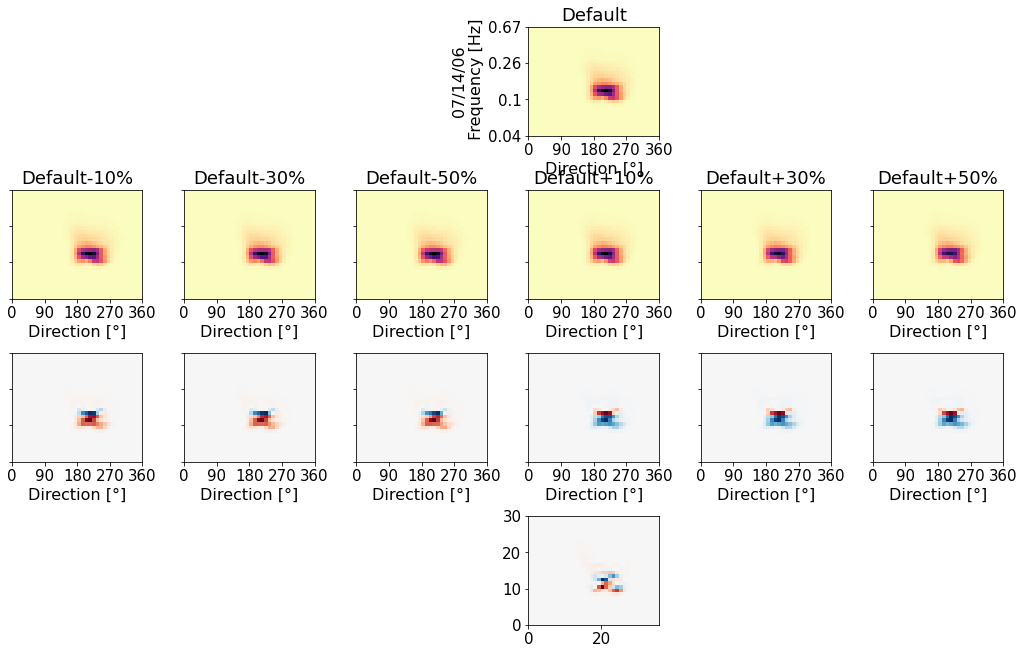

In [114]:
plotting_example_v2(default,objs,list_result,min_values,max_values)

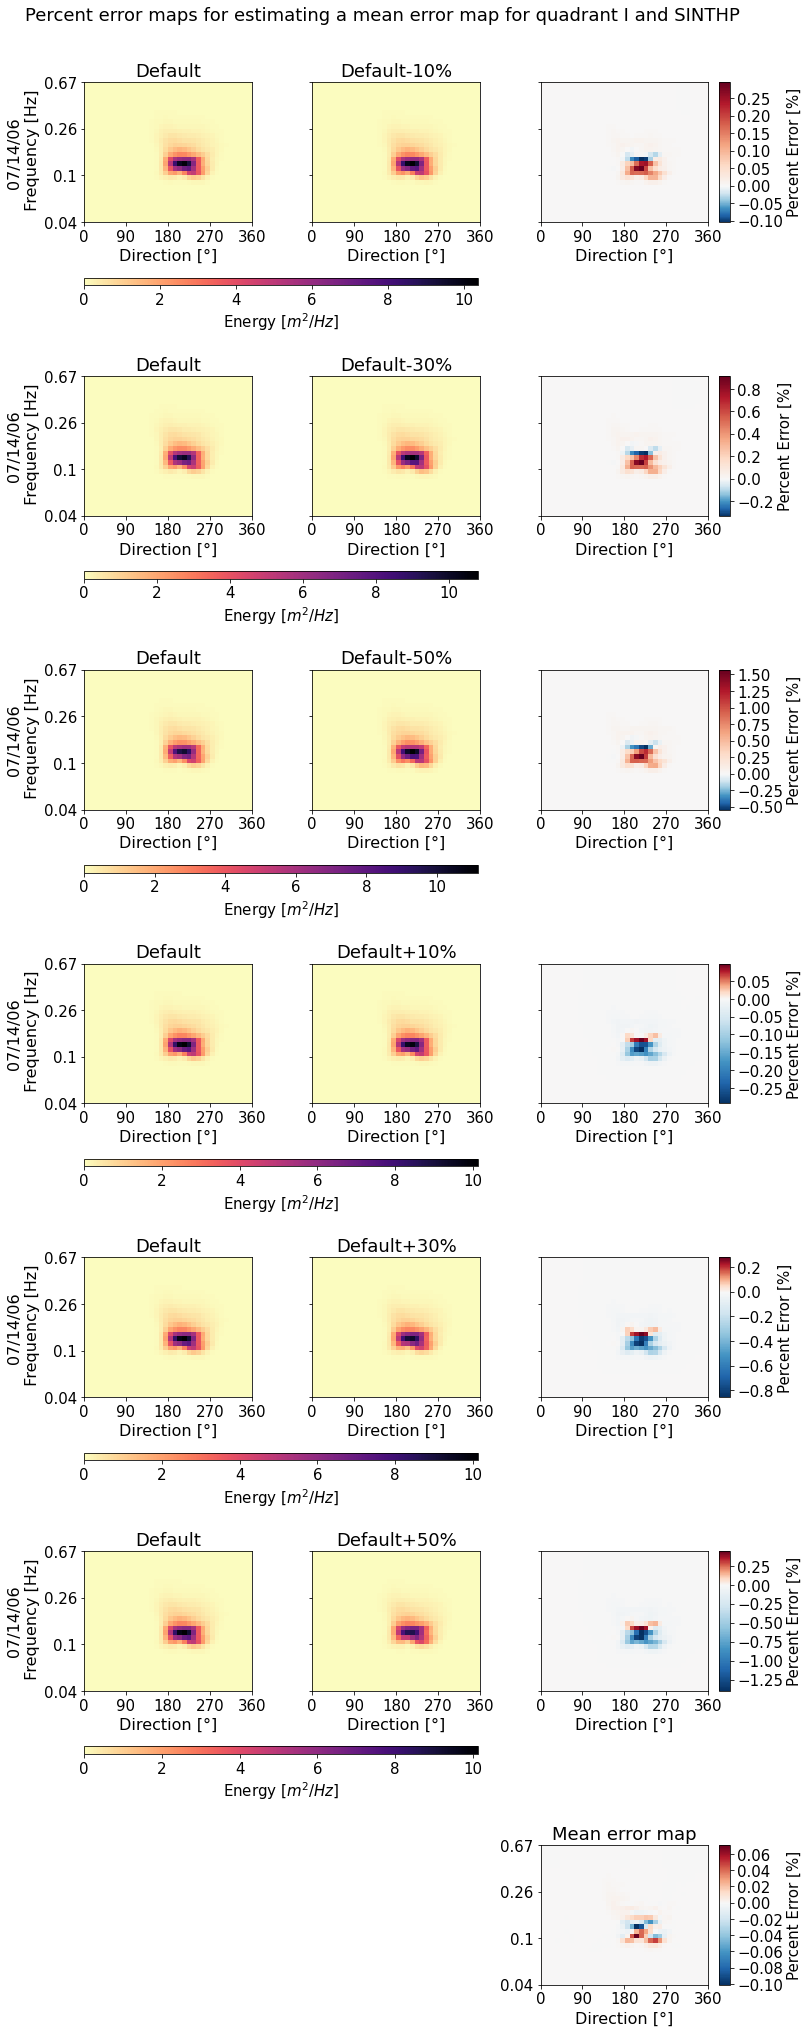

In [97]:
plotting_example(default,objs,list_result,min_values,max_values)

In [ ]:
def plotting_error_maps(fig,axes,idx,col,element,result,values):
      if axes.ndim==2:
        cf=axes[idx][col].imshow(result, cmap='bone_r',origin='lower',
                                      vmin=np.nanmin(values),vmax=np.nanmax(values),extent=[0,36,0,30]) 
        arranging_axes(axes[idx][col],0)
        if idx==0:
          if col==0:
            axes[idx][col].set_title('Center')             
          elif col==1:
            axes[idx][col].set_title('Quadrant I')
          elif col==2:
            axes[idx][col].set_title('Quadrant II')
          elif col==3:
            axes[idx][col].set_title('Quadrant III')
          else:
            axes[idx][col].set_title('Quadrant IV')
        if col==0:
          axes[idx][col].set_ylabel(data_str[element]+'\n Frequency [Hz]', multialignment='center')
          axes[idx][col].set_xlabel('Direction [°]') 
      else:
        cf=axes[col].imshow(result, cmap='bone_r',origin='lower',
                                      vmin=np.nanmin(values),vmax=np.nanmax(values),extent=[0,36,0,30]) 
        arranging_axes(axes[col],0)
        if col==0:
          axes[col].set_ylabel(data_str[element]+'\n Frequency [Hz]', multialignment='center')
          axes[col].set_xlabel('Direction [°]')         
      return cf

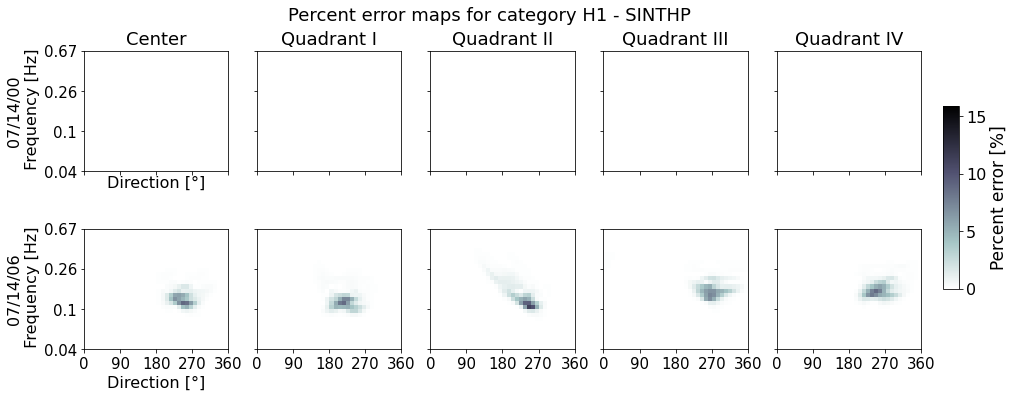

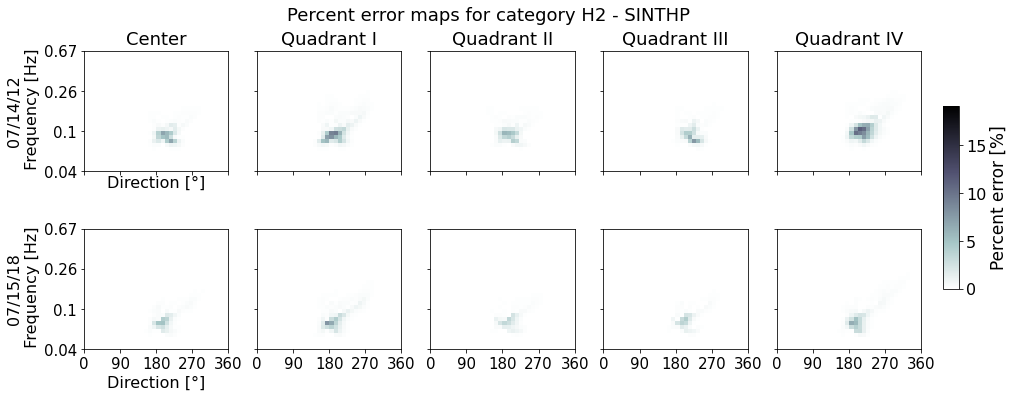

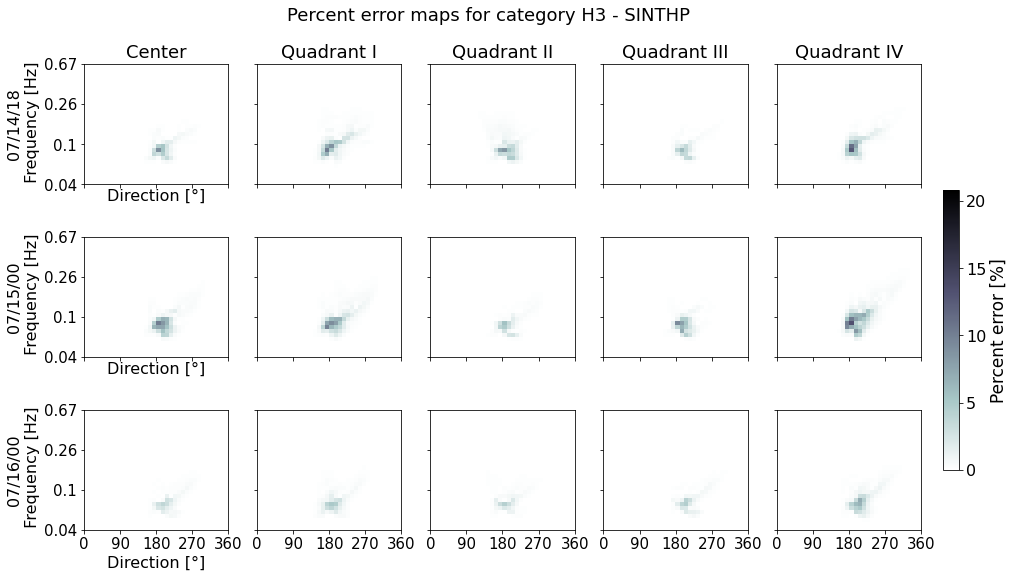

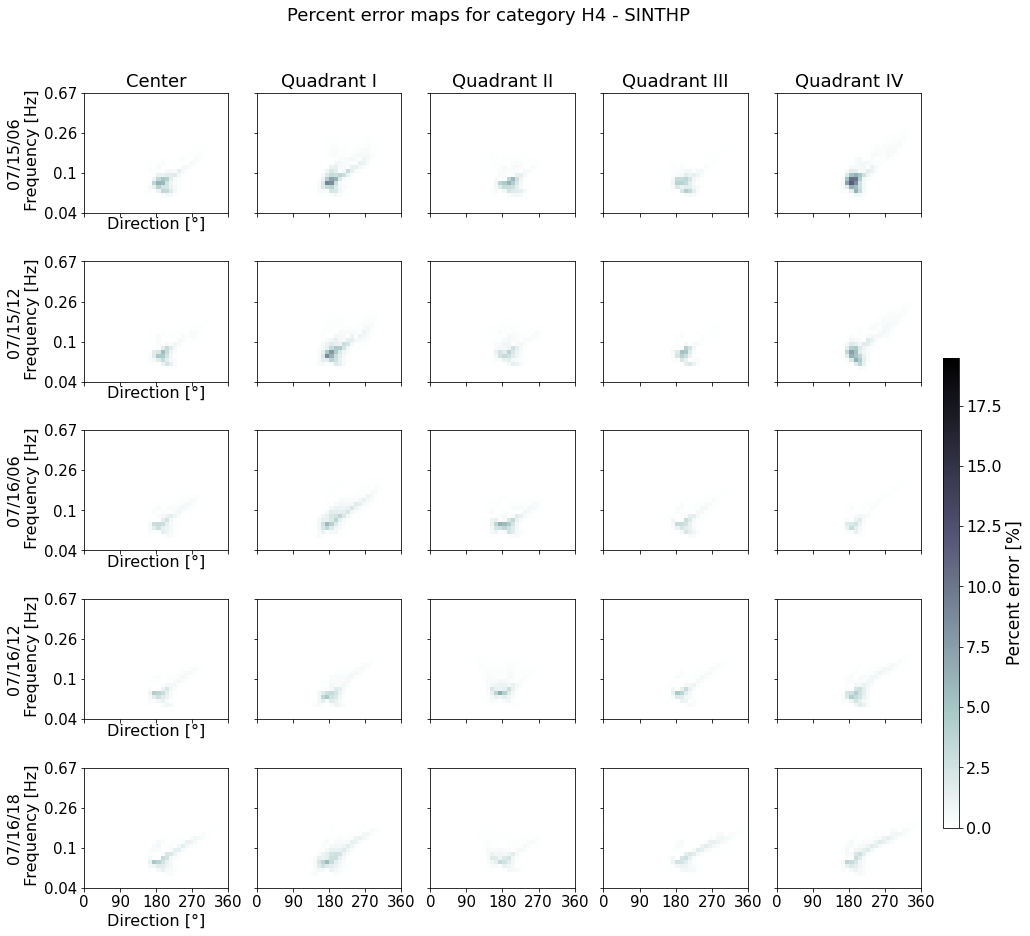

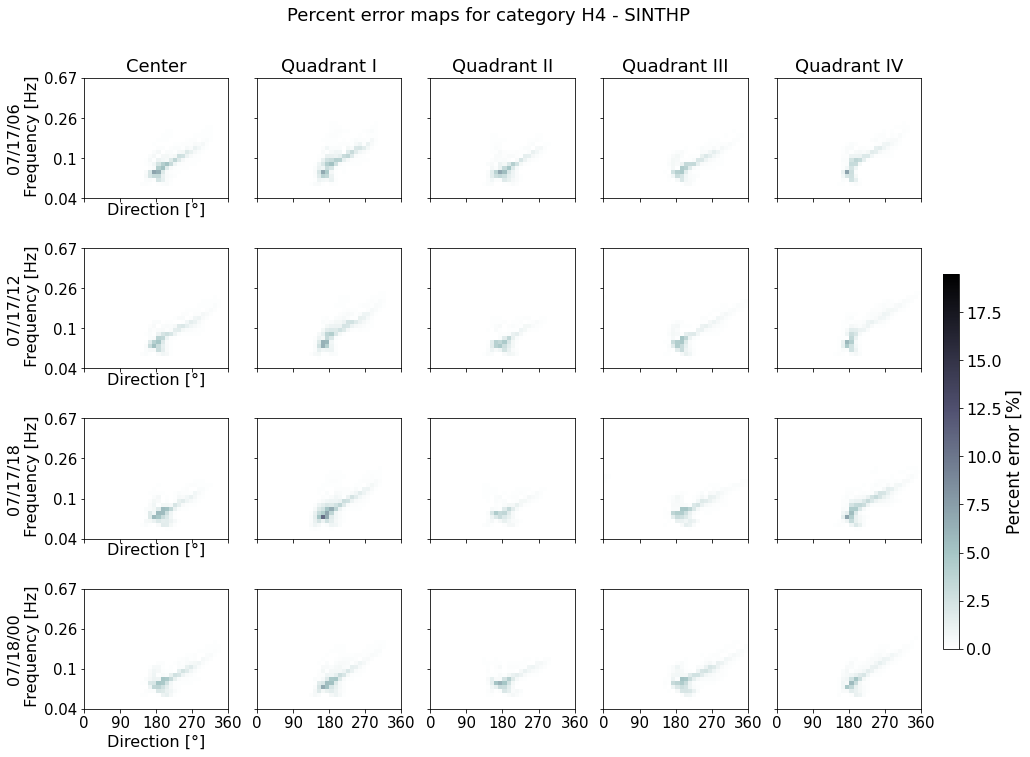

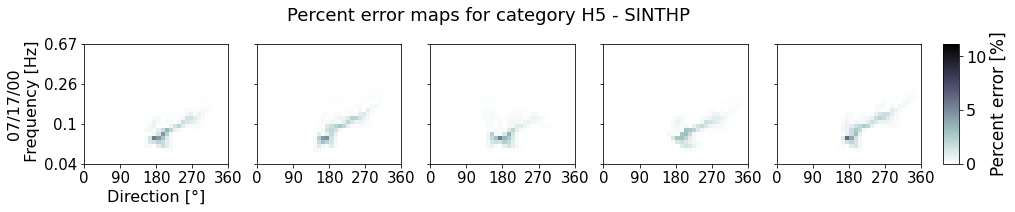

In [ ]:
cats=np.unique(cat_array)
for cat in cats:
  n_rows=int(len(dic_cats[cat]))
  if n_rows<5:
    fig, axes = plt.subplots(nrows=n_rows,ncols=5,figsize=(15,int(n_rows*3)),sharex=True,sharey=True)
    values=np.ones((n_rows,5,30,36))
    for idx,element in enumerate(dic_cats[cat]):
      for col in range(5):
        for param in specs_sw3.keys():
          if param !='SINTHP/0' and param[:6] =='SINTHP':
            default=np.reshape(specs_sw3['SINTHP/0'][:85,:,:],(17,5,30,36))
            obj=np.reshape(specs_sw3[param][:85,:,:],(17,5,30,36))
            result=(np.abs((obj[element,col,:,:]-default[element,col,:,:])/(np.nanmax(default[element,col,:,:]))))*100
            values[idx,col,:,:]=result
    for idx,element in enumerate(dic_cats[cat]):
      for col in range(5):
        results_list=[]
        for param in specs_sw3.keys():
          if param !='SINTHP/0' and param[:6] =='SINTHP':
            default=np.reshape(specs_sw3['SINTHP/0'][:85,:,:],(17,5,30,36))
            obj=np.reshape(specs_sw3[param][:85,:,:],(17,5,30,36))
            result=(np.abs((obj[element,col,:,:]-default[element,col,:,:])/(np.nanmax(default[element,col,:,:]))))*100
            results_list.append(result)
            plt.suptitle('Percent error maps for category '+cat+ ' - '+param[:6],y=0.95,fontsize=18)
        zeros=np.zeros(result.shape)        
        for el in results_list:
          zeros=zeros+el
        final_value=zeros/6
        cf=plotting_error_maps(fig,axes,idx,col,element,final_value,values)
    if axes.ndim==2:
      cax2= fig.add_axes([axes[-1][-1].get_position().x1+0.02,(axes[-1][-1].get_position().y0+axes[-1][-1].get_position().y1)/2,0.015,axes[0][-1].get_position().y1/2])
    else:
      cax2= fig.add_axes([axes[-1].get_position().x1+0.02,axes[-1].get_position().y0,0.015,axes[-1].get_position().height])
    cbar=plt.colorbar(cf,cax=cax2,orientation="vertical",pad=0.12)
    cbar.set_label(r'Percent error [%]',fontsize=17)
    cbar.ax.tick_params(labelsize=16)
  else:
    fig, axes = plt.subplots(nrows=5,ncols=5,figsize=(15,15),sharex=True,sharey=True)
    fig2, axes2 = plt.subplots(nrows=int(n_rows-5),ncols=5,figsize=(15,int((n_rows-5)*3)),sharex=True,sharey=True)
    values=np.ones((n_rows,5,30,36))
    for idx,element in enumerate(dic_cats[cat]):
      for col in range(5):
        for param in specs_sw3.keys():
          if param !='SINTHP/0' and param[:6] =='SINTHP':
            default=np.reshape(specs_sw3['SINTHP/0'][:85,:,:],(17,5,30,36))
            obj=np.reshape(specs_sw3[param][:85,:,:],(17,5,30,36))
            result=(np.abs((obj[element,col,:,:]-default[element,col,:,:])/(np.nanmax(default[element,col,:,:]))))*100
            values[idx,col,:,:]=result
    for idx,element in enumerate(dic_cats[cat]):
      for col in range(5):
        results_list=[]
        for param in specs_sw3.keys():
          if param !='SINTHP/0' and param[:6] =='SINTHP':
            default=np.reshape(specs_sw3['SINTHP/0'][:85,:,:],(17,5,30,36))
            obj=np.reshape(specs_sw3[param][:85,:,:],(17,5,30,36))
            result=(np.abs((obj[element,col,:,:]-default[element,col,:,:])/(np.nanmax(default[element,col,:,:]))))*100
            results_list.append(result)
            fig.suptitle('Percent error maps for category '+cat+ ' - '+param[:6],y=0.95,fontsize=18)
            fig2.suptitle('Percent error maps for category '+cat+ ' - '+param[:6],y=0.95,fontsize=18)
        zeros=np.zeros(result.shape)        
        for el in results_list:
          zeros=zeros+el
        final_value2=zeros/6
        if idx<=4:
          cf_init=plotting_error_maps(fig,axes,idx,col,element,final_value2,values)           
        else:
          idx_new=idx-5
          cf_end=plotting_error_maps(fig2,axes2,idx_new,col,element,final_value2,values)           
    cax_more5_1= fig.add_axes([axes[-1][-1].get_position().x1+0.02,(axes[-1][-1].get_position().y0+axes[-1][-1].get_position().y1)/2,
                        0.015,axes[0][-1].get_position().y1/2])
    cbar_more5_1=plt.colorbar(cf_init,cax=cax_more5_1,orientation="vertical",pad=0.12)
    cbar_more5_1.set_label(r'Percent error [%]',fontsize=17)
    cbar_more5_1.ax.tick_params(labelsize=16)

    cax_more5_2= fig2.add_axes([axes2[-1][-1].get_position().x1+0.02,(axes2[-1][-1].get_position().y0+axes2[-1][-1].get_position().y1)/2,
                        0.015,axes2[0][-1].get_position().y1/2])
    cbar_more5_2=plt.colorbar(cf_end,cax=cax_more5_2,orientation="vertical",pad=0.12)
    cbar_more5_2.set_label(r'Percent error [%]',fontsize=17)
    cbar_more5_2.ax.tick_params(labelsize=16)
  fig.savefig('/content/drive/Othercomputers/Mi PC/Tesis Maestria FranklinAyala/Scripts/Sensitivity analysis/mean_error_maps_'+'SINTHP_'+cat+'.png',
            dpi=1000,bbox_inches='tight',pad_inches=0.05)
  fig2.savefig('/content/drive/Othercomputers/Mi PC/Tesis Maestria FranklinAyala/Scripts/Sensitivity analysis/mean_error_maps_'+'SINTHP_'+cat+'_2.png',
            dpi=1000,bbox_inches='tight',pad_inches=0.05)
  plt.show()

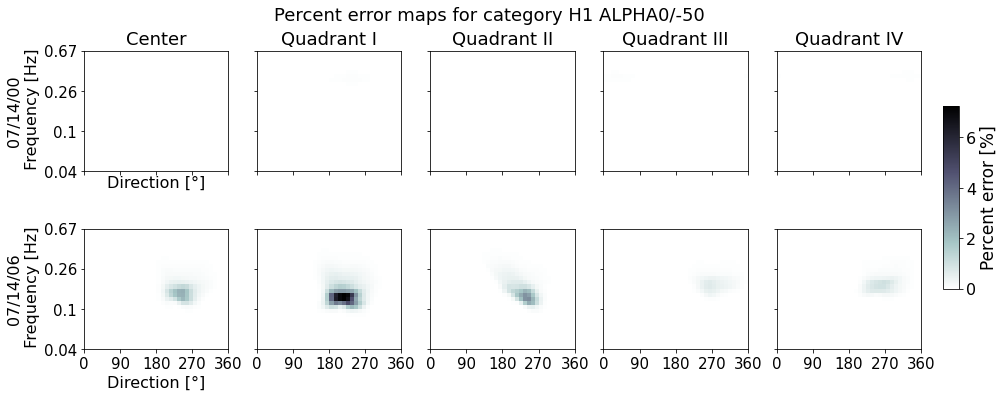

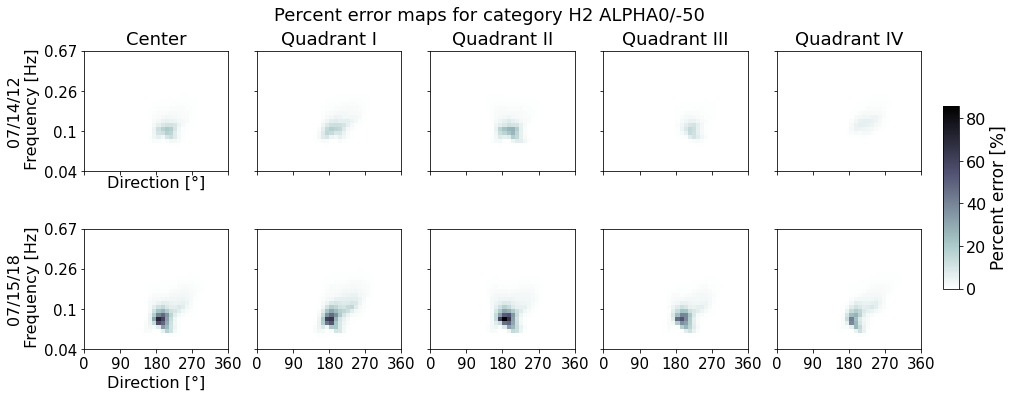

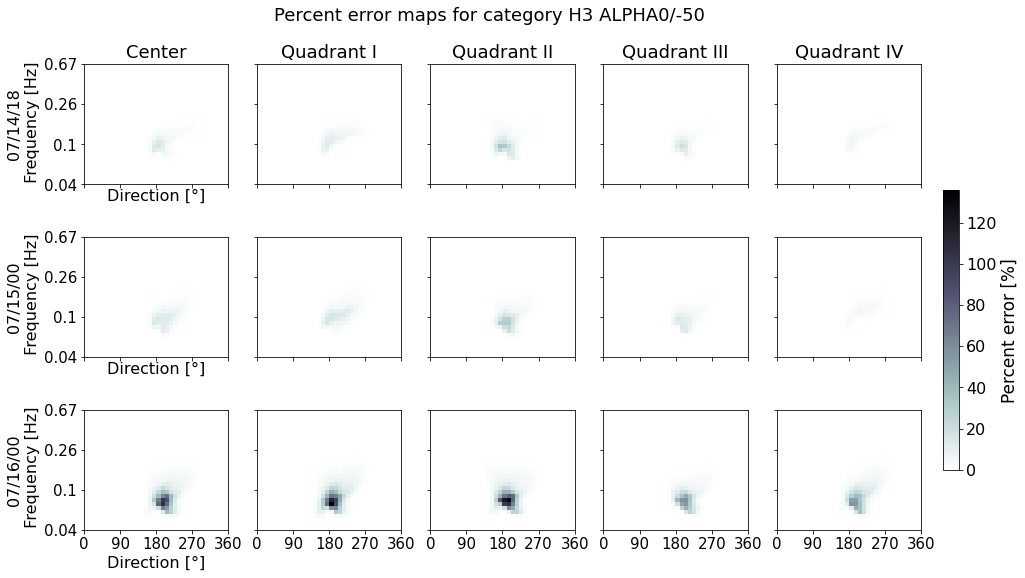

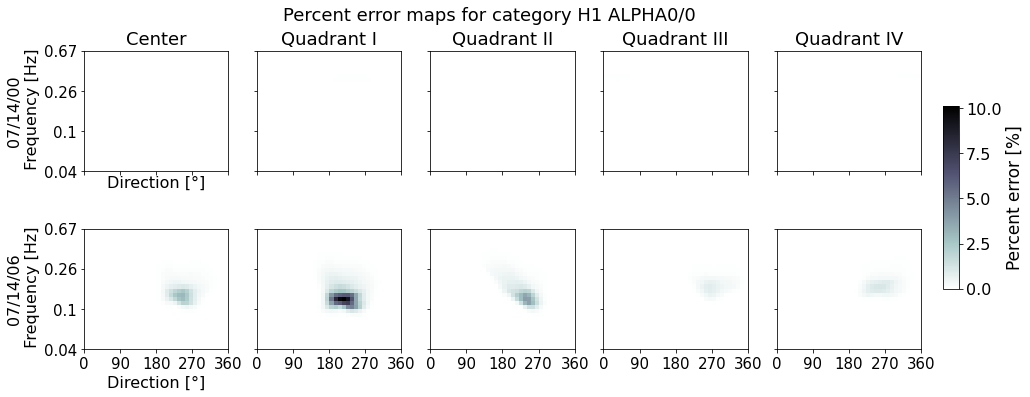

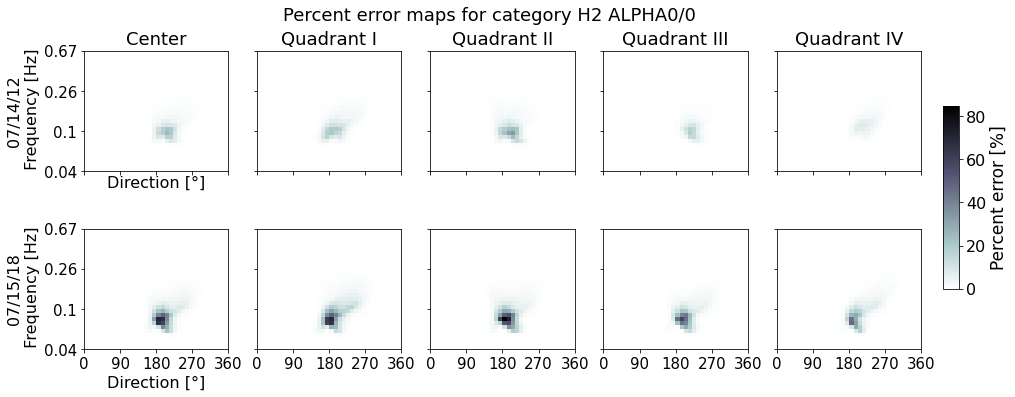

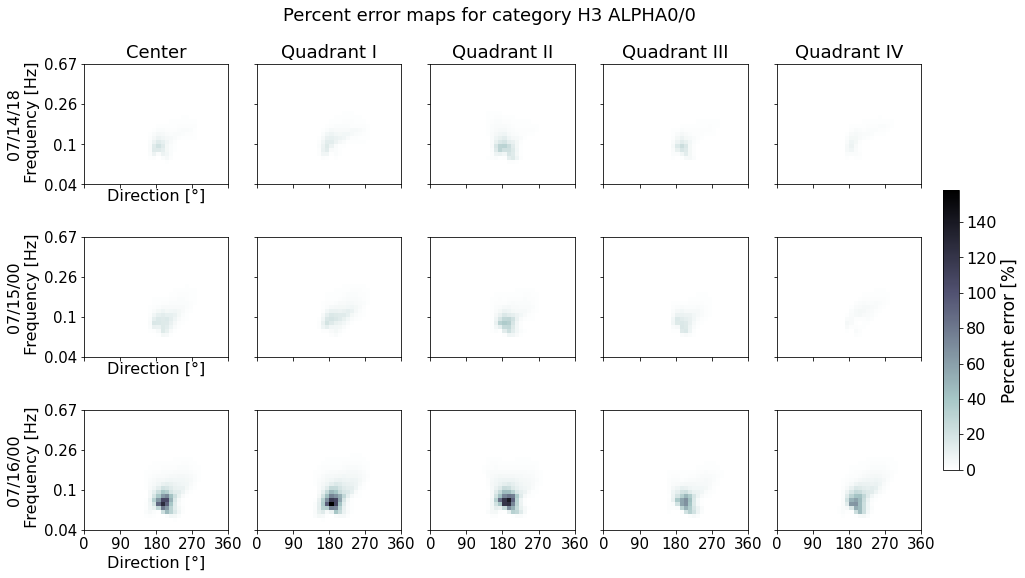

In [ ]:
for param in specs_sw3.keys():
  if param=='ALPHA0/-50' or param=='ALPHA0/0':
    to_plot=specs_sw3[param]
    #to_plot=(np.abs(specs_sw3[param]-specs_sw3['ALPHA0/0'])/(specs_sw3['ALPHA0/0']))*100
    cats=np.unique(cat_array)
    #percent=np.reshape(specs_sw3[param][:85,:,:],(17,5,30,36))
    #default=np.reshape(specs_sw3['ALPHA0/0'][:85,:,:],(17,5,30,36))
    #to_plot=np.abs((percent-default)/default)*100
    to_plot=np.reshape(to_plot[:85,:,:],(17,5,30,36))
    for cat in cats[:-1]:
      n_rows=int(len(dic_cats[cat]))
      if n_rows<5:
        fig, axes = plt.subplots(nrows=n_rows,ncols=5,figsize=(15,int(n_rows*3)),sharex=True,sharey=True)
        plt.suptitle('Percent error maps for category '+cat+ ' '+param,y=0.95,fontsize=18)
        values=np.ones((n_rows,5,30,36))
        for idx,element in enumerate(dic_cats[cat]):
          for col in range(5):
            values[idx,col,:,:]=to_plot[element,col,:,:]
        for idx,element in enumerate(dic_cats[cat]):
          for col in range(5):
            cf=axes[idx][col].imshow(to_plot[element,col,:,:], cmap='bone_r',origin='lower',vmin=np.nanmin(values),vmax=np.nanmax(values),extent=[0,36,0,30])      
            axes[idx][col].set_xticks(np.linspace(0,36,5))
            axes[idx][col].set_xticklabels(list(map(str,np.linspace(0,360,5,dtype=int))))
            axes[idx][col].set_yticks(np.arange(0,31,10))
            axes[idx][col].set_yticklabels(np.round([freqs[0],freqs[9],freqs[19],freqs[29]],2))
            if idx==0:
              if col==0:
                axes[idx][col].set_title('Center')             
              elif col==1:
                axes[idx][col].set_title('Quadrant I')
              elif col==2:
                axes[idx][col].set_title('Quadrant II')
              elif col==3:
                axes[idx][col].set_title('Quadrant III')
              else:
                axes[idx][col].set_title('Quadrant IV')
            if col==0:
              axes[idx][col].set_ylabel(data_str[element]+'\n Frequency [Hz]', multialignment='center')
              axes[idx][col].set_xlabel('Direction [°]') 
        cax2= fig.add_axes([axes[-1][-1].get_position().x1+0.02,(axes[-1][-1].get_position().y0+axes[-1][-1].get_position().y1)/2,0.015,axes[0][-1].get_position().y1/2])
        cbar=plt.colorbar(cf,cax=cax2,orientation="vertical",pad=0.12)
        cbar.set_label(r'Percent error [%]',fontsize=17)
        cbar.ax.tick_params(labelsize=16)

        #cbar.ax.set_title('Percent error [%]',fontsize=15,y=-5.5)
      plt.show()

# Plotting the integral parameters

In [ ]:
ds_parts=np.load('/content/drive/Othercomputers/Mi PC/Tesis Maestria FranklinAyala/Scripts/Sensitivity analysis/hs_part.npz',
                 allow_pickle=True)

In [ ]:
hs_parts_sw3=ds_parts['sw3'].flatten()[0]

In [ ]:
to_plot2=hs_parts_sw3['ALPHA0/-50']